In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
files = ["WineTRAIN", "WineTEST", "yogaTRAIN", "yogaTEST"]

def read_ucr(file):
    df = pd.read_csv(file, header=None, sep=None, engine="python")
    df = df.dropna(axis=1, how="all")
    y  = df.iloc[:, 0].astype(float).astype(int)
    X  = df.iloc[:, 1:].astype(float)
    return X, y

datasets = {name: read_ucr(name) for name in files}

X_w_tr, y_w_tr = datasets["WineTRAIN"]
X_w_te, y_w_te = datasets["WineTEST"]
X_y_tr, y_y_tr = datasets["yogaTRAIN"]
X_y_te, y_y_te = datasets["yogaTEST"]


Wine TRAIN: shape=(57, 234), классы=[np.int64(1), np.int64(2)]


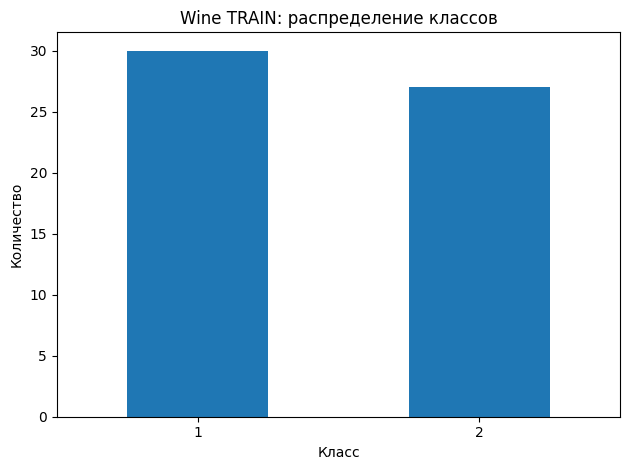

Yoga TRAIN: shape=(300, 426), классы=[np.int64(1), np.int64(2)]


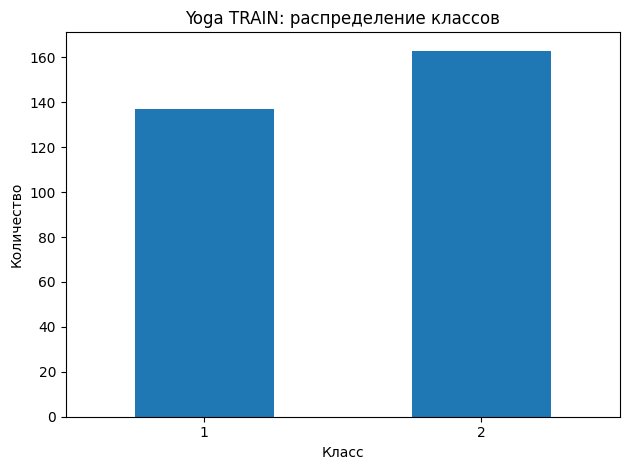

In [3]:
def show_basic_info(name, X, y):
    print(f"{name}: shape={X.shape}, классы={sorted(np.unique(y))}")
    ax = (pd.Series(y)
          .value_counts()
          .sort_index()
          .plot(kind="bar", title=f"{name}: распределение классов"))
    ax.set_xlabel("Класс")
    ax.set_ylabel("Количество")
    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

show_basic_info("Wine TRAIN", X_w_tr, y_w_tr)
show_basic_info("Yoga TRAIN", X_y_tr, y_y_tr)

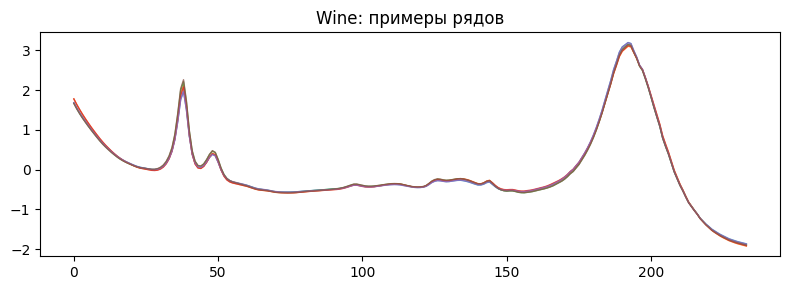

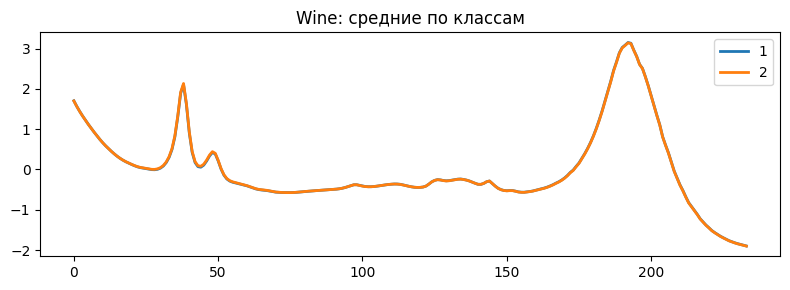

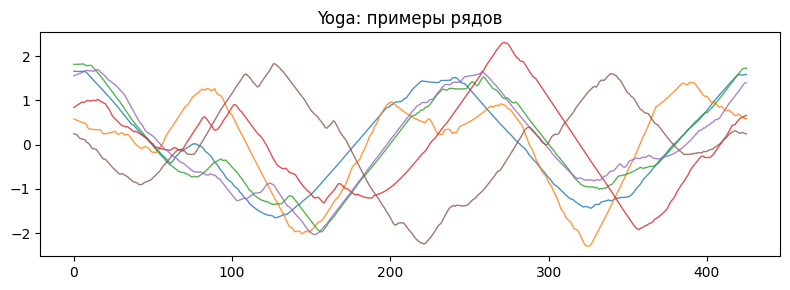

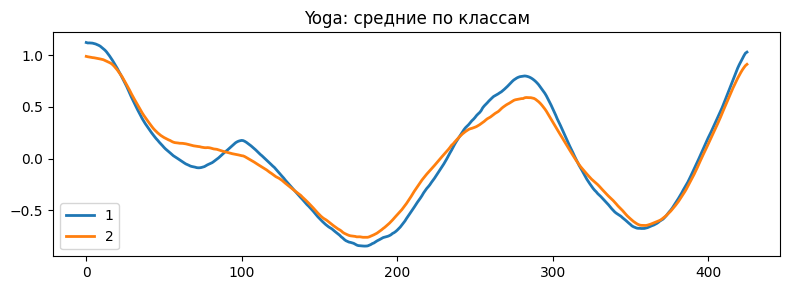

In [4]:
rng = np.random.default_rng(42)

def plot_samples(X, y, title, per_class=3):
    plt.figure(figsize=(8,3))
    for c in np.unique(y):
        idx = np.where(y==c)[0]
        for i in rng.choice(idx, size=min(per_class, len(idx)), replace=False):
            plt.plot(X.iloc[i].values, alpha=.8, linewidth=1)
    plt.title(f"{title}: примеры рядов"); plt.tight_layout(); plt.show()

def plot_means(X, y, title):
    plt.figure(figsize=(8,3))
    for c in np.unique(y):
        plt.plot(X[y==c].mean().values, label=str(int(c)), linewidth=2)
    plt.title(f"{title}: средние по классам"); plt.legend(); plt.tight_layout(); plt.show()

plot_samples(X_w_tr, y_w_tr, "Wine")
plot_means(X_w_tr, y_w_tr, "Wine")

plot_samples(X_y_tr, y_y_tr, "Yoga")
plot_means(X_y_tr, y_y_tr, "Yoga")

,dataset,model,cv_mean,test_acc
0,Wine,SVM_RBF,0.966667,0.796296
1,Wine,1NN,0.983333,0.574074


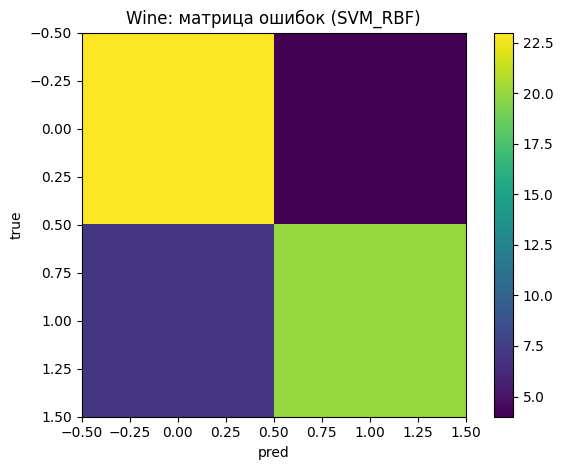

,dataset,model,cv_mean,test_acc
0,Yoga,1NN,0.786667,0.834000
1,Yoga,SVM_RBF,0.813333,0.823667


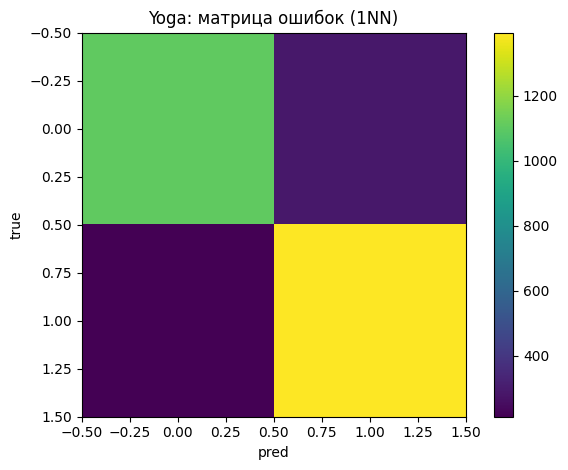

In [5]:
def eval_models(Xtr, ytr, Xte, yte, name):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models = {
        "1NN": make_pipeline(StandardScaler(), KNeighborsClassifier(1)),
        "SVM_RBF": make_pipeline(StandardScaler(), SVC(kernel="rbf", C=10, gamma="scale")),
    }
    rows = []
    best_name, best_cm, best_acc = None, None, -1
    for mname, model in models.items():
        cv_acc = cross_val_score(model, Xtr, ytr, cv=cv, scoring="accuracy").mean()
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        acc = accuracy_score(yte, pred)
        rows.append([name, mname, cv_acc, acc])
        if acc > best_acc:
            best_acc, best_name, best_cm = acc, mname, confusion_matrix(yte, pred)
    df = pd.DataFrame(rows, columns=["dataset","model","cv_mean","test_acc"])
    display(df.sort_values("test_acc", ascending=False).reset_index(drop=True))

    plt.imshow(best_cm, interpolation="nearest")
    plt.title(f"{name}: матрица ошибок ({best_name})"); plt.colorbar()
    plt.xlabel("pred"); plt.ylabel("true"); plt.tight_layout(); plt.show()

eval_models(X_w_tr, y_w_tr, X_w_te, y_w_te, "Wine")
eval_models(X_y_tr, y_y_tr, X_y_te, y_y_te, "Yoga")